In [26]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time

# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [27]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [28]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
train_X = cifar_trainset.data
train_y = cifar_trainset.targets
test_X = cifar_testset.data
test_y = cifar_testset.targets

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x

In [31]:
train_X = torch.tensor(train_X).permute(0, 3, 1, 2)
test_X = torch.tensor(test_X).permute(0, 3, 1, 2)

train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)
train_y = (torch.tensor(train_y, dtype=torch.int64)).to(device)
test_y = (torch.tensor(test_y, dtype=torch.int64)).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_21796\1387114815.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_21796\1387114815.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)


In [32]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=32, shuffle=True)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
losses = []
test_losses = []
train_losses = []
for epoch in range(20):
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 500 == 0:
            output = model(val_x)
            loss_train = criterion(output, val_y)
            output = model(test_X)
            loss_test = criterion(output, test_y)
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
            output_test = model(test_X)
            test_losses.append(loss_test.item())
            train_losses.append(loss_train.item())
    #print(loss.item())
    
    


Epoch 0, step 0, train_loss 2.328413724899292, test_loss 2.3107802867889404
Epoch 0, step 500, train_loss 1.9385509490966797, test_loss 1.940504550933838


KeyboardInterrupt: 

Test accuracy: 0.2774


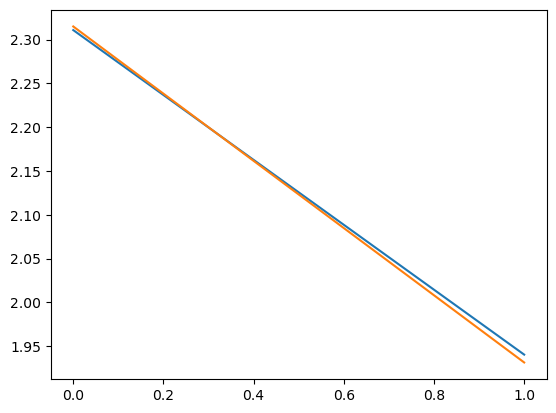

In [34]:
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [35]:
plot_hessian(model, criterion, x_samples, y_samples)

KeyboardInterrupt: 